In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from control import lqr
from single_photons.estimators.kalman import KalmanFilter
import single_photons.utils.constants as ct
from single_photons.environment import Particle

In [3]:
T = 293
p = 1e-6
R = 147e-9
rho = 2200
index_refraction = 1.4440
tweezer_wavelength = 1.55e-6
tweezer_power = 200e-3
tweezer_waist = 0.6e-6
cavity_waist = 100e-6
cavity_length = 50e-3
eta_detec = 0.178

In [4]:
m_p = 4 / 3 * np.pi * R**3 * rho
v_gas = np.sqrt(3 * ct.kb * T / ct.m_gas)
Nm = rho/(ct.amu*60.08) #SiO2 molecular density
tweezer_freq = 2 * np.pi * ct.c / tweezer_wavelength
pol_permit_ratio = 3/Nm*(index_refraction**-1)/(index_refraction**2+2) #from C-M
gamma = 15.8 * R**2 * p / (m_p * v_gas)
omega = (
    np.sqrt(12 / np.pi)
    * np.sqrt((index_refraction**2 - 1) / (index_refraction**2 + 2)) ** 3
    * np.sqrt(tweezer_power)
    / (tweezer_waist**2 * np.sqrt(rho * ct.c))
)

coupling = 6.68e-42

period = 2 * np.pi / omega
delta_t = 1e-9
control_step = 30 # defined as int, number of time steps of simulation necessary to compute the control policy
t = np.arange(0, 50 * period, delta_t)
N = t.shape[0]

In [5]:
env = Particle(omega, gamma, coupling, eta_detection=eta_detec, T=T)

In [6]:
variance_process = 4 * ct.kb * env.T * env.__gamma__ * env._m_ / (env.zp_p**2)
print(variance_process)
variance_process = variance_process + np.power(env.backaction / env.zp_p, 2)
print(variance_process)
std_detection = 0.5

17408.382805058605
150286.73477987695


In [1]:
variance_process

NameError: name 'variance_process' is not defined

In [6]:
Q = np.array([[0, 0], [0, variance_process]])
R = np.array([[np.power(std_detection,2)]])

In [18]:
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
cost_states = np.array([[omega, 0],
                        [0, omega]])
(G, S, E) = lqr(Ad, env.B*delta_t*control_step, cost_states, 10*omega)

x0 = 10
P0 = 10*np.matrix(np.eye(2))
estimation = np.matrix([[x0], [0]])
states = np.array([[0], [0]])
G

array([[-22288604.55239651,  66338061.81206017]])

In [19]:
new_states = np.zeros((N, 2))
measured_states = np.zeros((N))
estimated_states = np.zeros((N, 2))
estimated_states[0, :] = estimation.reshape((2))
estimation = estimation.reshape((2, 1))
control = np.array([[0]])
controls = []
kalman = KalmanFilter(estimation, P0, Ad, env.B * delta_t * control_step, env.C, Q * delta_t * control_step, R)
for i in tqdm(range(t.shape[0])):
    new_states[i, :] = states[:, 0]
    if not i % control_step:
        measured_states[i] = states[0, 0] + std_detection * np.random.normal()
        kalman.propagate_dynamics(control)
        kalman.compute_aposteriori(measured_states[i])
        estimated_states[i, :] = kalman.estimates_aposteriori[int(i/control_step)][:, 0].reshape((2))
        estimation = estimated_states[i, :].reshape((2, 1))
        control = -1e-3*np.matmul(G, estimation)
    else:
        measured_states[i] = measured_states[i-1]
        estimated_states[i, :] = estimated_states[i-1,:]
    controls.append(float(control))
    states = env.step(states, control=control, delta_t=delta_t)

100%|████████████████████████████████████████████████████████████████| 767586/767586 [00:16<00:00, 46962.25it/s]


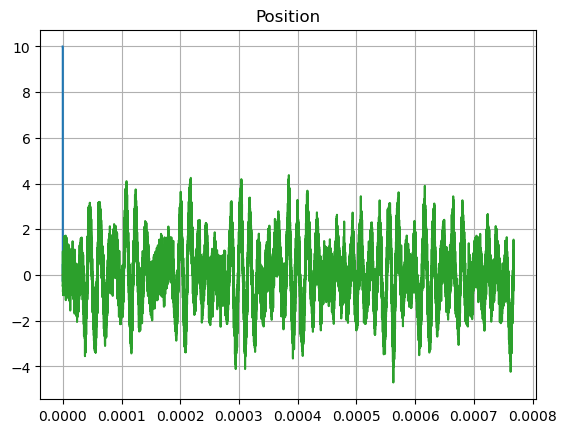

In [20]:
fig = plt.Figure()
plt.title('Position')
plt.plot(t, estimated_states[:,0])
plt.plot(t, new_states[:,0])
plt.plot(t, measured_states)
plt.grid()
plt.show()

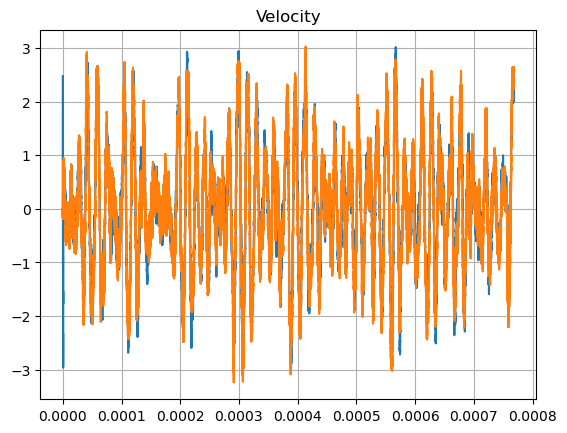

In [21]:
fig = plt.Figure()
plt.title('Velocity')
plt.plot(t, estimated_states[:,1])
plt.plot(t, new_states[:,1])
plt.grid()
plt.show()

In [62]:
z = estimated_states[:,0]*env.zp_x
p = estimated_states[:,1]*env.zp_p

KeyboardInterrupt: 

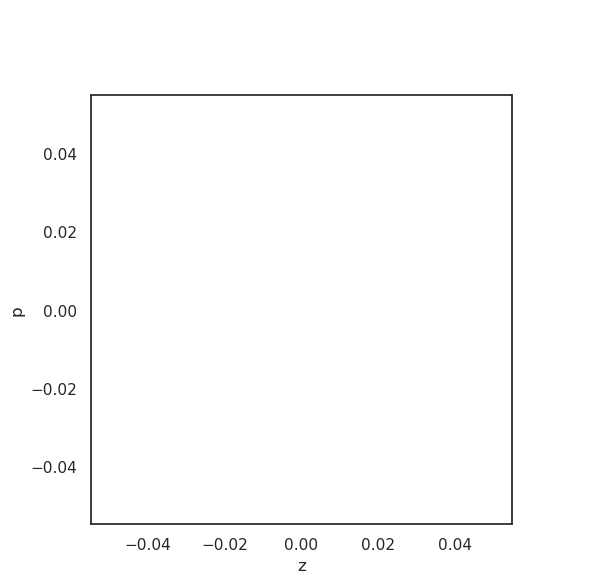

In [63]:
sns.set_theme(style="white")
df = pd.DataFrame()
df['z'] = estimated_states[100:,0]
df['p'] = estimated_states[100:,1]
g = sns.JointGrid(data=df, x="z", y="p", space=0)
g.plot_joint(sns.lineplot, sort = False)#clip=((2200, 6800), (10, 25)),
             #thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.kdeplot, alpha=1, fill=True)
g.set_axis_labels(r'$z/z_{zp}$',r'$p/p_{zp}$')

In [ ]:
plt.plot(df['z'], df['p'])

In [28]:
cov_mat = kalman.error_covariance_aposteriori[-1]
z_std = env.zp_x*np.sqrt(cov_mat[0,0])
p_std = env.zp_p*np.sqrt(cov_mat[1,1])
cov_mat

matrix([[   4.38134092,   44.24232617],
        [  44.24232617, 1068.02087968]])

In [29]:
estimated_states[-30:].var(axis=0)

array([  2.62312317, 191.82738379])

In [34]:
(env._m_*np.power(env.__omega__, 2)*np.power(z_std,2)+np.power(p_std,2)/env._m_)/(2*hbar*env.__omega__)

0.22116627475764986

In [37]:
z_std*p_std > hbar/2

True